PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 5 Working with Images

These methods can be helpful, especially if you do not know beforehand of which type your image is. First lets initialize ImageJ, import some packages and load in some test data.

In [1]:
import imagej

# initialize ImageJ
ij = imagej.init(mode='interactive')
print(f"ImageJ version: {ij.getVersion()}")

log4j:WARN No appenders could be found for logger (org.bushe.swing.event.EventService).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.


ImageJ version: 2.3.0/1.53f


### 5.1 Opening images with `ij.io().open()`

Images can be opened with ImageJ with `ij.io().open()`. This returns the opened image as an ImageJ2 `Dataset` (a Java object). Using `ij.io().open()` allows you to take advantage of the `Bio-Formats` image read/write and `SCIFIO` image conversion when using Fiji endpoints (_e.g._ `sc.fiji:fiji`). Lets load some data:

In [2]:
# load local test data
dataset = ij.io().open('sample-data/test_timeseries.tif')

# load web test data
web_image = ij.io().open('https://wsr.imagej.net/images/Cell_Colony.jpg')

[INFO] Populating metadata


[java.lang.Enum.toString] [INFO] Populating metadata


You can view images with `ij.py.show()`. Note that `dataset` is 4D (see the next section) and will not be viewable via `ij.py.show()`. The `show()` method expects a simple 2D image. You can view 4D data in ImageJ's viewer with `ij.ui().show()` (this only works locally with `mode='interactive'`). In section 5.3 we will slice `dataset` to extract a single 2D image to view with `ij.py.show()`.

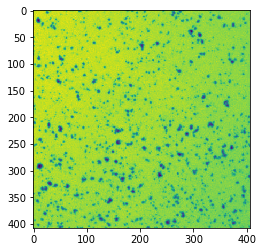

In [3]:
# show the web image
ij.py.show(web_image)

In [4]:
# show the 4D dataset in ImageJ's viewer
ij.ui().show(dataset)

### 5.2 Working with the `dims` module

The sample data `test_timeseries.tif` is a 4D (X, Y, Channel, Time) dataset of a HeLa cell infected with a modified HIV-1 fluorescent reporter virus. This reporter virus is designed to express two flourscent proteins upon viral gene expression. Here is the breakdown of the channels:

| Channel | psedu-color | purpose |
| :---: | :---: | :---: |
| 1 | Blue | Nuclear marker |
| 2 | Red | Early viral gene expression |
| 3 | Green | Late viral gene expression / viral particle formation |

With the `dims` module we can get the shape and dimensions of the data:

In [5]:
import imagej.dims as dims

print(f"shape: {dims.get_shape(dataset)}")
print(f"dimensions: {dims.get_dims(dataset)}")

shape: [250, 250, 3, 15]
dimensions: ['X', 'Y', 'Channel', 'Time']


The same methods can also be used on Python objects as well:

In [6]:
# convert the ImageJ image (Java) to an xarray.DataArray (Python)
xarr = ij.py.from_java(dataset)

print(f"shape: {dims.get_shape(xarr)}")
print(f"dimensions: {dims.get_dims(xarr)}")

shape: [15, 250, 250, 3]
dimensions: ('t', 'row', 'col', 'ch')


You can also get the shape of ImageJ images with the `.shape` attribute, like you do with NumPy/xarray arrays.

In [7]:
# print dataset and xarray shape
print(dataset.shape)
print(xarr.shape)

(250, 250, 3, 15)
(15, 250, 250, 3)


**Important**: Note the difference in shape and dimension order between the ImageJ and xarray images. ImageJ images use `[X, Y, Channel, Z, Time]` dimension labels and order. NumPy images use `[t, pln, row, col, ch]` Where `row` and `col` correspond to `Y` and `X` respectively.

Its also important to note that not all images objects (Java and Python) have dimension metadata. In these cases `get_dims` will just return the shape of the image.

In [8]:
# get numpy array from xarray
arr = xarr.data

# check dimensions on the numpy array returns just the shape
print(dims.get_dims(arr))

(15, 250, 250, 3)


### 5.3 Slicing Python and Java images

Let's slice and view the test data. Note the change in dimension order depending on the object you are working with.

In [9]:
# slice the test data
java_slice = dataset[:, :, 1, 10]
python_slice = xarr[10, :, :, 1]

# print slice shape
print(f"java_slice: {java_slice.shape}")
print(f"python_slice: {python_slice.shape}")

java_slice: (250, 250)
python_slice: (250, 250)


**Important**: When you slice an ImageJ image (_i.e._ a `RandomAccessibleInterval`) an `IntervalView` is returned. Depending on what you're doing this object type could be and you can continue with your workflow. In this case however, we need to wrap/convert the `IntervalView` returned from the slicing operation as an `ImgPlus`. Then we can use `ij.py.show()` to view the slice. For more information on `RandomAccessibleIntervals` check out the ImageJ wiki [here](https://imagej.net/libs/imglib2/accessibles).

java_slice type: <java class 'net.imglib2.view.IntervalView'>


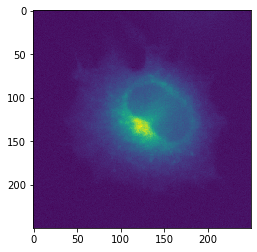

In [10]:
print(f"java_slice type: {type(java_slice)}")

# wrap as ImgPlus -- you can also wrap the slice as a dataset with ij.py.to_dataset()
img = ij.py.to_img(java_slice)
ij.py.show(img)

python_slice type: <class 'xarray.core.dataarray.DataArray'>


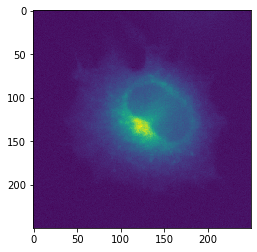

In [11]:
print(f"python_slice type: {type(python_slice)}")

# xarray images can just be displayed
ij.py.show(python_slice)